In [1]:
import wandb
import pandas as pd
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
WANDB_ENTITY = 'darayavaus'
WANDB_PROJECT = 'rank_binary_search'

In [6]:
api = wandb.Api()

In [7]:
df = pd.DataFrame([], columns=['orig_macs', 'redc_macs', 'best_rank', 
                               'lname', 'eps', 'decomposition'])
runs = api.runs('/'.join((WANDB_ENTITY, WANDB_PROJECT)))

i = 0
for run in tqdm(runs):
    if run.state == 'finished':
        df.loc[i] = [None] * len(df.columns)
        
        df.loc[i]['lname'] = run.config['lname']
        df.loc[i]['eps'] = run.config['eps']
        df.loc[i]['decomposition'] = run.config['decomposition']
        
        df.loc[i]['orig_macs'] = run.summary['orig_macs']
        df.loc[i]['redc_macs'] = run.summary['redc_macs']
        df.loc[i]['best_rank'] = run.summary['best_rank']
        
        i += 1
        
df.head()

  0%|          | 0/70 [00:00<?, ?it/s]

,orig_macs,redc_macs,best_rank,lname,eps,decomposition
0,115605504,32597348,644,layer4.0.conv2,0.005,cp3
1,57802752,23241435,307,layer4.0.conv1,0.005,cp3
2,115605504,12553016,248,layer4.1.conv2,0.005,cp3
3,115605504,25561585,505,layer4.1.conv1,0.005,cp3
4,115605504,22465520,220,layer3.1.conv2,0.005,cp3


In [8]:
df_slice = df[(df.decomposition=='cp3') & (df.eps==0.005)].sort_values('lname')
df_slice

,orig_macs,redc_macs,best_rank,lname,eps,decomposition
15,115605504,26207552,61,layer1.0.conv1,0.005,cp3
14,115605504,23629760,55,layer1.0.conv2,0.005,cp3
13,115605504,31363136,73,layer1.1.conv1,0.005,cp3
12,115605504,27066816,63,layer1.1.conv2,0.005,cp3
11,57802752,40362672,131,layer2.0.conv1,0.005,cp3
10,115605504,26385520,127,layer2.0.conv2,0.005,cp3
9,115605504,32618320,157,layer2.1.conv1,0.005,cp3
8,115605504,23476880,113,layer2.1.conv2,0.005,cp3
7,57802752,22082340,145,layer3.0.conv1,0.005,cp3
6,115605504,22771868,223,layer3.0.conv2,0.005,cp3


In [14]:
# conv1 + 3 downsamples + fc
rest_macs = 118013952 + 3* 6422528 + 512000

In [18]:
(df_slice.redc_macs.sum() + rest_macs) / (df_slice.orig_macs.sum() + rest_macs), \
df_slice.redc_macs.sum() / df_slice.orig_macs.sum()

(0.39531666421972406, 0.34561049070394817)

In [9]:
layer2rank = {record['lname']:record['best_rank'] for record in df_slice[['lname', 'best_rank']].to_dict('records')}
layer2rank

{'layer1.0.conv1': 61,
 'layer1.0.conv2': 55,
 'layer1.1.conv1': 73,
 'layer1.1.conv2': 63,
 'layer2.0.conv1': 131,
 'layer2.0.conv2': 127,
 'layer2.1.conv1': 157,
 'layer2.1.conv2': 113,
 'layer3.0.conv1': 145,
 'layer3.0.conv2': 223,
 'layer3.1.conv1': 231,
 'layer3.1.conv2': 220,
 'layer4.0.conv1': 307,
 'layer4.0.conv2': 644,
 'layer4.1.conv1': 505,
 'layer4.1.conv2': 248}

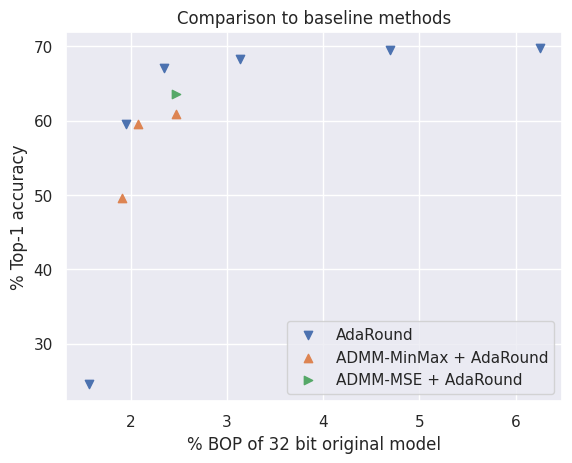

In [21]:
#### plt.axhline(y=69.76, color='skyblue', linestyle = '-', label='original model')
# plt.scatter([1.56, 3.13, 6.25], [5.78, 18.87, 69.76], marker='o', label='Quantization')
plt.scatter([1.56, 1.95, 2.34, 3.13, 4.69, 6.25], [24.535, 59.58, 67.01, 68.28, 69.52, 69.7], marker='v', label='AdaRound')
# plt.scatter([2.07, 2.47], [55.52, ], marker='s', label='ADMM+Quantization')
plt.scatter([1.91, 2.07, 2.47], [49.64, 59.53, 60.93], marker='^', label='ADMM-MinMax + AdaRound')
plt.scatter([2.47], [63.59], marker='>', label='ADMM-MSE + AdaRound')

plt.legend()
plt.xlabel('% BOP of 32 bit original model')
plt.ylabel('% Top-1 accuracy')
plt.title('Comparison to baseline methods')

plt.savefig('comparison')
plt.show()

In [85]:
def quantize_tensor_mse(x, bits, qscheme=None, scale=None):
    def _quantize(x_float, maxval, per_channel_axis=0):
        mantissa_bits = torch.tensor(3)
        exponent_bits = 7 - mantissa_bits
        
        if maxval.shape and maxval.shape[0] != 1 and len(maxval.shape) != len(x_float.shape):
            new_shape = [1] * len(x_float.shape)
            new_shape[per_channel_axis] = -1
            maxval = maxval.view(new_shape)
        
        bias = 2 ** exponent_bits - torch.log2(maxval) + torch.log2(2 - 2 ** (-mantissa_bits)) - 1
        print(bias)
        x_clipped = torch.min(torch.max(x_float, -maxval), maxval)

        log_scales = torch.floor(torch.log2(torch.abs(x_clipped)) + bias).detach()
        log_scales = torch.clamp(log_scales, 1.)

        scales = 2. ** (log_scales - mantissa_bits - bias)

        return torch.round(x_clipped / scales) * scales
    
    mx = torch.max(torch.abs(x.min()), torch.abs(x.max()))
    lsp = [torch.linspace(0.1 * mx.item(), 1.2 * mx.item(), 111)]
    # 111 x 1
    linspaces = torch.stack(lsp).to(x.device).transpose(0, 1)
    
    mses = torch.zeros_like(linspaces)
    
    meandims = list(torch.arange(len(x.shape)))
    
    for i, maxval in enumerate(linspaces):
        xfp = _quantize(x, maxval)
        mse = ((x - xfp) ** 2).mean(dim=meandims)
        mses[i, :] = mse
        print(maxval, mse)

    best_mse = mses.argmin(0)
    maxval = torch.tensor([linspaces[best_mse[i], i] for i in range(linspaces.shape[-1])]).to(x.device)

    return _quantize(x, maxval)

In [86]:
quantize_tensor_mse(torch.tensor([-1,2,3,-4,5,6, 1000]), bits=8)

tensor([9.3561])
tensor([100.]) tensor(115714.2891)
tensor([9.2186])
tensor([110.]) tensor(113157.1406)
tensor([9.0931])
tensor([120.]) tensor(110628.5859)
tensor([8.9776])
tensor([130.]) tensor(108128.5703)
tensor([8.8707])
tensor([140.]) tensor(105657.1406)
tensor([8.7712])
tensor([150.]) tensor(103214.3047)
tensor([8.6781])
tensor([160.]) tensor(100800.0078)
tensor([8.5906])
tensor([170.]) tensor(98414.2656)
tensor([8.5081])
tensor([180.]) tensor(96057.1406)
tensor([8.4301])
tensor([190.]) tensor(93728.5781)
tensor([8.3561])
tensor([200.]) tensor(91428.5703)
tensor([8.2858])
tensor([210.]) tensor(89157.1719)
tensor([8.2186])
tensor([220.]) tensor(86914.2891)
tensor([8.1545])
tensor([230.]) tensor(84700.0234)
tensor([8.0931])
tensor([240.]) tensor(82514.2969)
tensor([8.0342])
tensor([250.]) tensor(80357.1484)
tensor([7.9776])
tensor([260.]) tensor(78228.5781)
tensor([7.9232])
tensor([270.]) tensor(76128.5859)
tensor([7.8707])
tensor([280.]) tensor(74057.1406)
tensor([7.8201])
tensor(

tensor([-9.7656e-01,  1.9531e+00,  2.9297e+00, -3.9062e+00,  4.8828e+00,
         5.8594e+00,  1.0000e+03])